In [18]:
import MRA_generate as generate
import symae_core as symae
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("TensorFlow Version: ", tf.__version__)

# Build SymAE
class SymAE(tf.keras.Model):
    def __init__(self,N=1000,nt=20,d=100,p=8,q=22,kernel_size=5,filters=64): 
        '''
        class SymAE is the complete AutoEncoder

        Parameters
        ----------
        # Parameters related to data itself
        N : int
            N is the Cardinality of the data set X, say n_X in the paper
        nt : int
            nt is the number of instances in each X_i, say n_tau in the paper (Xi[1]...Xi[nt])
        d : int
            d is the dimensions of each "fundamental" data, say d=dim Xi[j] (e.g. d=28*28 for mnist)
        # Parameters related to SymAE
        p : int
            Symmetric encoder latent dimensions, p=dim Ci (Coherent Code)
        q : int
            Nuisance encoder latent dimensions, q=dim Ni[j] (Dissimilar Code)
        # Parameters related to NeuralNets
        kernel_size : int
            The size of the convolution window
        filters : int 
            How many filters in each convolution layer
        '''
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_enc_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='sym_enc_input')
        sym_enc_output=symae.SymmetricEncoder1D(kernel_size,filters,[2,2,2,2],[2,2,2,2],p)(sym_enc_input)
        sym_encoder=tfk.Model(sym_enc_input, sym_enc_output, name='sym_encoder')
        # Build nuisance encoder
        nui_enc_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='sym_enc_input')
        nui_enc_output=symae.NuisanceEncoder1D(kernel_size,filters,[2,2,2],[2,2,2,2],q)(nui_enc_input)
        nui_enc_flatten=tfkl.Flatten()(nui_enc_output)
        nui_encoder=tfk.Model(nui_enc_input, nui_enc_flatten, name='nui_encoder')
        # Build distribute in decoder
        distribute_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        distribute_output=symae.DistributeZsym(nt, p, q)(distribute_input)
        distzsym = tfk.Model(distribute_input, distribute_output, name='distzsym')
        #Build mixer in decoder
        mixer_input = tfk.Input(shape=(nt,p+q), name='mixer_input')
        mixer_output=symae.Mixer1D(kernel_size,filters,10,d)(mixer_input)
        mixer = tfk.Model(mixer_input, mixer_output, name='mixer') 
        # Build encoder
        encoder_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance=nui_encoder(encoder_input)
        zsym=sym_encoder(encoder_input)
        latentcat=symae.LatentCat(0.65) #0.4 droupout
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        #Build SymAE
        self.symae=tf.keras.Model(encoder_input, decoder(encoder_output) , name='autoencoder_clone')
    def call(self, input_tensor):
        return self.symae(input_tensor)
    def model(self, x):
        return tfk.Model(inputs=x, outputs=self.call(x))

# Generate MRA Data and Train SymAE
class MRA():
    def __init__(self,N=1000,nt=20,d=100,p=8,q=22,ne=10,sigma=0.1,kernel_size=5,filters=64):
        '''
        Initialization
        
        Parameters
        ----------
        # Parameters related to my specific algorithm of generating MRA data
        ne : int
            Only use g0,g1...g_{ne-1} in generate_smooth
        sigma : int
            The standard deviation of the noise
        # Other parameters are the same as in class SymAE, see them above
        
        Yields
        ----------
        self.SymAE : keras.engine.functional.Functional
            The whole SymAE structure, defined using tf.keras.Model.
        self.X : numpy.ndarray
            The MRA data set.
        '''
        autoencoder_input=tfk.Input(shape=(nt,d,1), dtype='float32', name='autoencoder_input')
        self.model=tf.keras.Model(autoencoder_input,SymAE(N,nt,d,p,q,kernel_size,filters)(autoencoder_input),name='SymAE_model_in_MRA')
        self.X=generate.generate_smooth(d,nt,N,ne,sigma)
        self.p=p
        self.q=q
    def train(self,epochs=50):
        '''
        Train SymAE
        
        Parameters
        ----------
        epochs : int
            Epochs of training
        
        Yields
        ----------
        self.history : keras.callbacks.History
            Output of model.fit()
        self.Y : numpy.ndarray
            Output of SymAE net, has the same shape as self.X
        '''
        self.model.compile(optimizer='adam', loss='mse')
        self.model.summary()
        self.history=self.model.fit(self.X,self.X,epochs=epochs)
        self.Y=self.model.predict(self.X)
    def plot(self,I=0,J=5,fontsize=25,figsize=(24,10)):
        '''
        Plot X,Y and savefig
        
        Parameters
        ----------
        I : int
            Plot X[I,:,:]
        J : int
            Plot X[I,1:J,:]
        fontsize : int
            Font size of matplotlib
        figsize : tuple
            Size of the figure

        Yields
        ----------
        A figure named 'result.png' is saved at the same directory
        '''
        plt.rc('font', size=fontsize)
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
        fig.suptitle('p=%d, q=%d'%(self.p,self.q))
        axs[0].set_title('input')
        axs[1].set_title('output')
        for j in range(J):
            axs[0].plot(range(100),self.X[I,j,:],label='%d'%j)
        for j in range(J):
            axs[1].plot(range(100),self.Y[I,j,:],label='%d'%j)
        for ax in axs.flat:
            ax.grid(True)
            ax.set(xlabel='x',ylabel='value')
        fig.savefig('result.png')


Num GPUs Available:  2
TensorFlow Version:  2.9.1


Model: "SymAE_model_in_MRA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLay  [(None, 20, 100, 1)]     0         
 er)                                                             
                                                                 
 sym_ae_3 (SymAE)            (None, 20, 100, 1)        198293    
                                                                 
Total params: 198,293
Trainable params: 198,037
Non-trainable params: 256
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 4s 41ms/step - loss: 0.3225
Epoch 2/50
32/32 [==============================] - 1s 29ms/step - loss: 0.0954
Epoch 3/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0733
Epoch 4/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0658
Epoch 5/50
32/32 [==============================] 

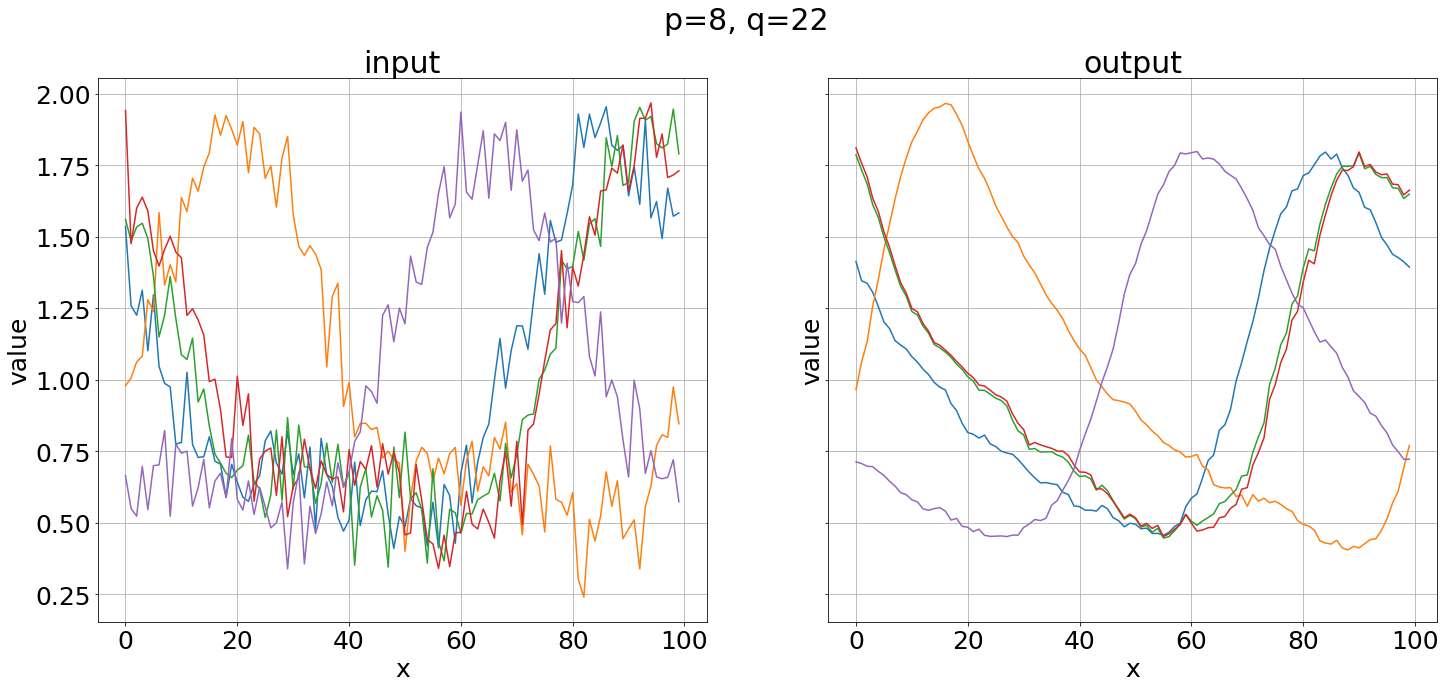

In [19]:
mra=MRA()
mra.train()
mra.plot()